In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from theano import shared
print('Running on PyMC3 v{}'.format(pm.__version__))


Running on PyMC3 v3.11.2


## EDA - Pre-omicron

In [3]:
pre_omi = pd.read_csv('data/pre-omi.csv')
pre_omi.sample(20)

,Test Date,WRRF Name,Gene Copies (N1/L),Per Capita Gene Copies,"Population Served, estimated",School Status,School-Aged Population,Season,Holiday
1022,2021-06-28,26th Ward,670.0,410468.71,290608,Summer Break_2,72091.0,Summer 2021,0
1311,2021-09-13,Port Richmond,6094.0,3059951.58,226167,Summer Break_2,46435.0,Summer 2021,0
262,2020-11-02,Red Hook,775.0,471227.90,224029,All Grades,33636.0,Fall 2020,0
315,2020-11-16,Oakwood Beach,2693.0,1162443.48,258731,All Grades,44374.0,Fall 2020,0
1225,2021-08-18,Oakwood Beach,3140.0,1212774.97,258731,Summer Break_2,44374.0,Summer 2021,0
363,2020-11-25,Wards Island,8601.0,4579501.72,1201485,Shutdown,240219.0,Fall 2020,0
1038,2021-06-30,Coney Island,1696.0,649336.78,682342,Summer Break_2,117865.0,Summer 2021,0
735,2021-03-29,Oakwood Beach,8302.0,4129631.02,258731,High_Schools_Reopen,44374.0,Spring 2021,0
418,2020-12-09,Tallman Island,15365.0,7627405.37,449907,Grade Schools Reopen,74748.0,Fall 2020,0
862,2021-05-17,Owls Head,5167.0,1747889.57,906442,High_Schools_Reopen,135396.0,Spring 2021,0


In [4]:
pre_omi.isnull().sum()

Test Date                        15
WRRF Name                         0
Gene Copies (N1/L)              112
Per Capita Gene Copies          112
Population Served, estimated      0
School Status                     0
School-Aged Population            0
Season                            0
Holiday                           0
dtype: int64

In [6]:
pre_omi.dropna(inplace=True)


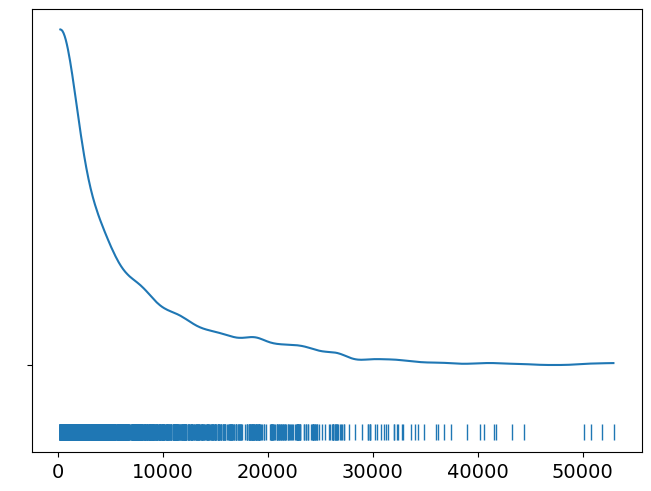

In [9]:
# Non-log-transformed target shape
az.plot_kde(pre_omi['Gene Copies (N1/L)'].values, rug=True)
plt.yticks([0], alpha=0);

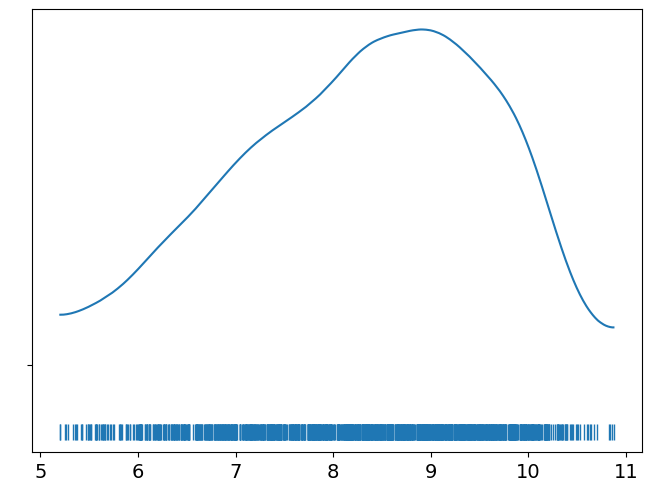

In [10]:
# log-transformed target shape
pre_omi_logs = np.log(pre_omi['Gene Copies (N1/L)'].values)
az.plot_kde(pre_omi_logs, rug=True)
plt.yticks([0], alpha=0);

In [12]:
# Setting aside some log test data
# Creating some train and test for later 
import random

sample_value = int(len(pre_omi_logs) * .2) # test size
pre_omi_logs = list(pre_omi_logs) # convert to list in order to sample
pre_omi_logs_test = random.sample(pre_omi_logs, sample_value) # random sampling

pre_omi_logs_test = np.array(pre_omi_logs_test) # convert to array

pre_omi_logs_train = [x for x in pre_omi_logs if x not in pre_omi_logs_test] # get train values if not in test values
pre_omi_logs_train = np.array(pre_omi_logs_train) # convert to array
pre_omi_logs = np.array(pre_omi_logs) # re-convert to array


In [13]:
# Getting min and max to set as mu priors
pre_omi_min = min(pre_omi_logs)
pre_omi_max = max(pre_omi_logs)
data = {'Min Value': [pre_omi_min], 'Max Value': [pre_omi_max]}
df = pd.DataFrame(data)
df.head()

,Min Value,Max Value
0,5.198497,10.877292


In [15]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=5.19, upper=10.877)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=pre_omi_logs)
    trace_g = pm.sample(1000, tune=1000)

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_49007/1580424220.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


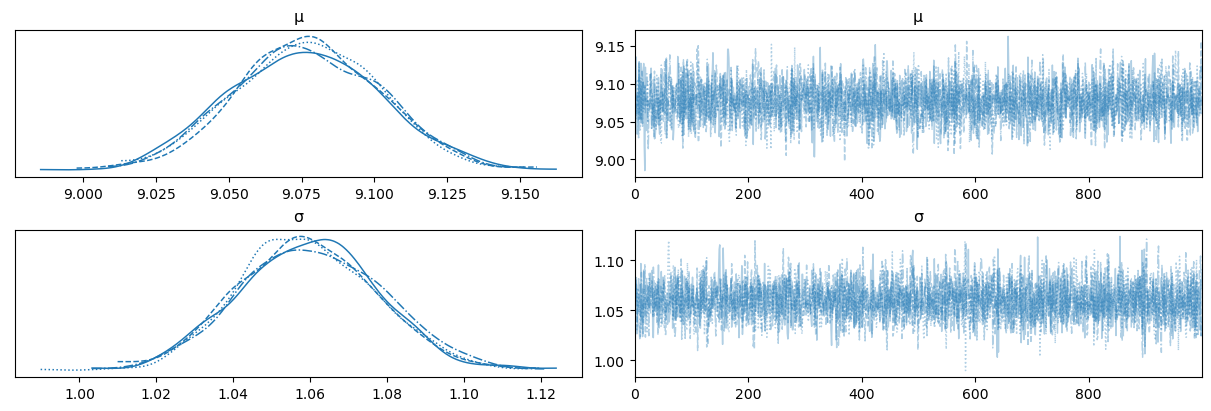

In [33]:
az.plot_trace(trace_g);

In [16]:
with model_g:
    summary = pm.summary(trace_g, hdi_prob=0.94)  # 94% HPD
print(summary)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
μ  8.305  0.034   8.245    8.373      0.001      0.0    3913.0    2453.0  \
σ  1.243  0.024   1.202    1.289      0.000      0.0    3892.0    3117.0   

   r_hat  
μ    1.0  
σ    1.0  


In [ ]:
# Good convergence (r_hat) and low error (msce) so looks like our posteriors are pretty good, though not quite as good
# as with post-omicron. This is to be expected given high divergence during first year of covid.

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


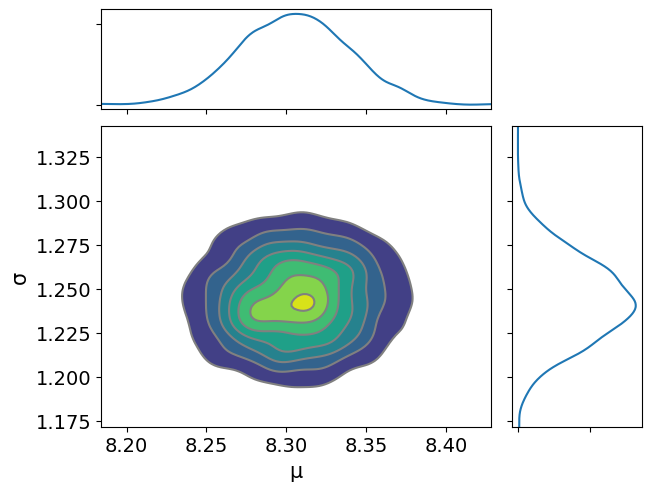

In [17]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

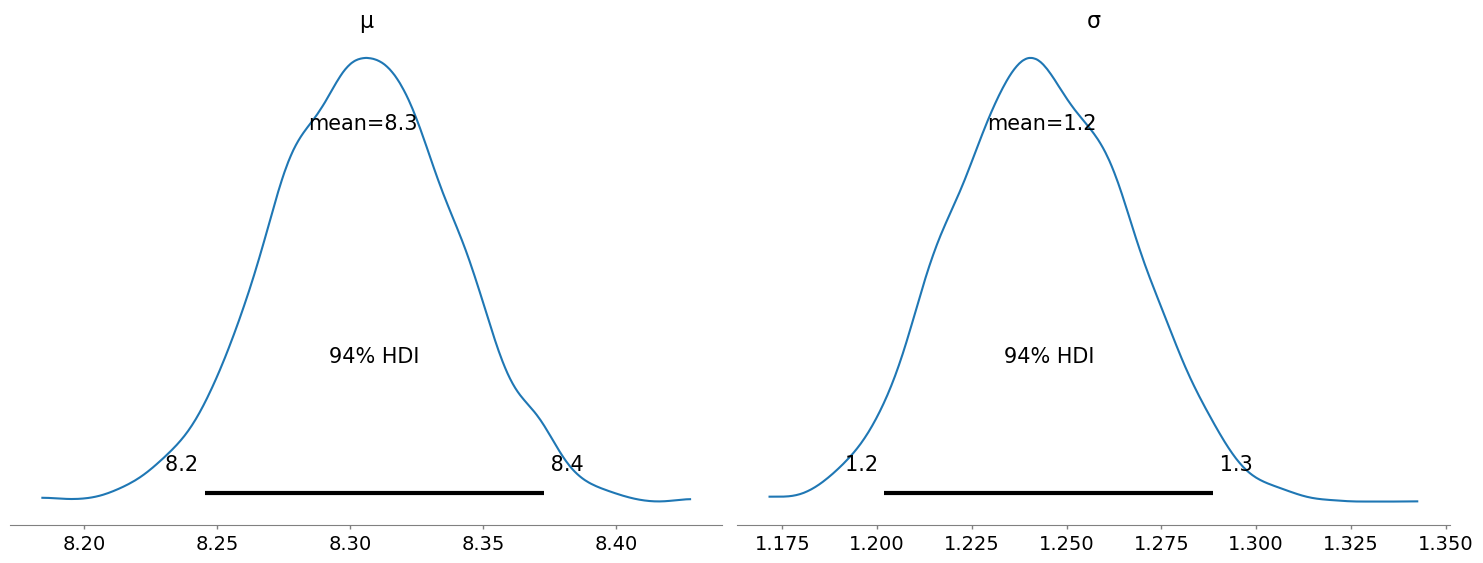

In [18]:
# Separately normally distributed mu and sigma, mostly circular kde, so looks pretty good! mu and sigma are fairly independent.

az.plot_posterior(trace_g);

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_49007/2972755431.py:10: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))
/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Text(0.5, 1.0, 'BFMI = [1.10177819 1.30577128 1.34918508 1.22199394]\nGelman-Rubin = 1.0')

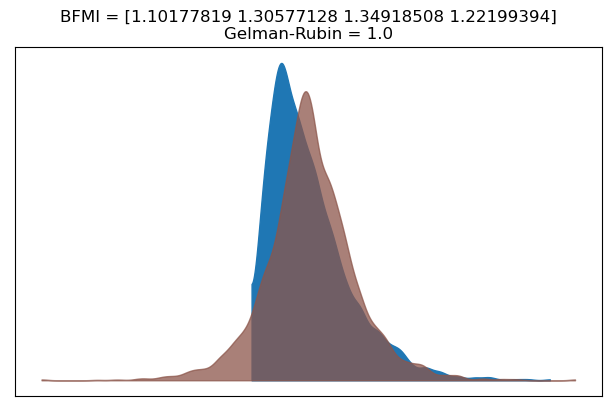

In [19]:
bfmi = pm.bfmi(trace_g)

# get gelman-rubin
summary = pm.summary(trace_g, hdi_prob=0.94)  # 0.94 for a 94% Highest Density Interval (HDI)

# extract gelman-rubin
max_gr = summary['r_hat'].max()


pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))

In [20]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(1000, 1372)

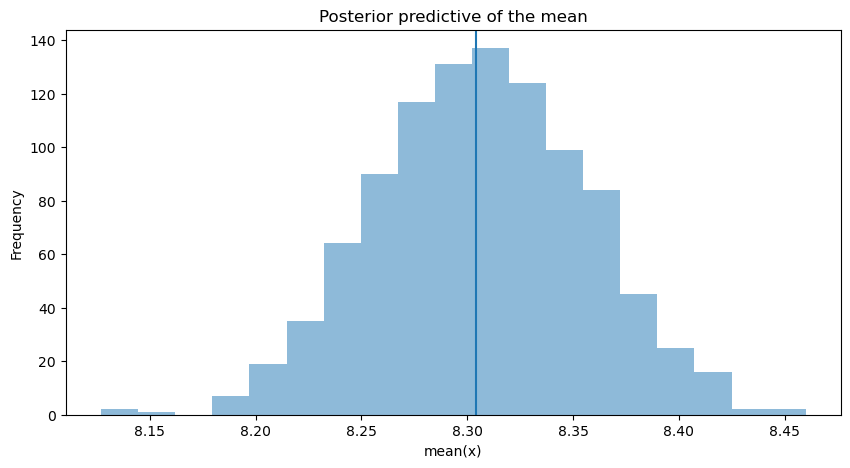

In [22]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(pre_omi_logs.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [24]:
# Inferred very close to actual mean! Our posteriors seem pretty solid. 


# Let's break down our target data by categorical data. 

target = pre_omi_logs.copy()
idx = pd.Categorical(pre_omi['WRRF Name'],
                     categories=['26th Ward', 'Bowery Bay', 'Coney Island', 'Hunts Point', 'Jamaica Bay', 
                                 'North River', 'Oakwood Beach','Newtown Creek', 'Owls Head',
                                'Port Richmond', 'Red Hook', 'Rockaway', 'Tallman Island', 'Wards Island']).codes
groups = len(np.unique(idx))

In [25]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=5, shape=groups) # lower mu since expecting variation between min and max
    σ = pm.HalfNormal('σ', sd=2, shape=groups) # higher sd since less certainty between groups

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=target)

    trace_groups = pm.sample(5000, tune=5000)

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_49007/3369262307.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_groups = pm.sample(5000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 39 seconds.


In [26]:
ww_by_site = az.from_pymc3(trace=trace_groups)
ww_gaussian = az.summary(ww_by_site)
ww_gaussian

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],8.107,0.124,7.869,8.335,0.001,0.000,37358.0,14248.0,1.0
μ[1],8.386,0.124,8.151,8.618,0.001,0.000,37259.0,14771.0,1.0
μ[2],8.460,0.118,8.239,8.682,0.001,0.000,38206.0,15260.0,1.0
μ[3],8.077,0.128,7.838,8.320,0.001,0.000,37120.0,14884.0,1.0
μ[4],8.485,0.140,8.223,8.753,0.001,0.001,37538.0,14402.0,1.0
μ[5],7.917,0.120,7.689,8.138,0.001,0.000,36365.0,14772.0,1.0
μ[6],8.646,0.104,8.447,8.838,0.001,0.000,38768.0,14840.0,1.0
μ[7],8.134,0.121,7.902,8.356,0.001,0.000,35358.0,14804.0,1.0
μ[8],8.979,0.109,8.774,9.184,0.001,0.000,38047.0,15144.0,1.0
μ[9],8.348,0.124,8.111,8.582,0.001,0.000,34541.0,14668.0,1.0


In [ ]:
# Our priors are very pretty strong! Standard deviations are fairly low, though again, not as low as with our post-Omicron
# data. This is to be expected!

In [27]:
# Let's try making predictions: 

with comparing_groups:
    posterior_pred = pm.sample_posterior_predictive(trace_groups, samples=500)


/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


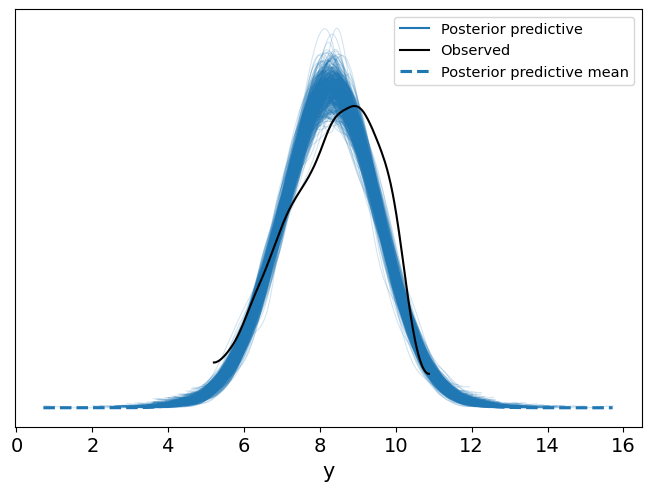

In [28]:
# Convert to arviz's data structure
data_az = az.from_pymc3(trace=trace_groups, posterior_predictive=posterior_pred)

# Plot observed data and posterior predictive means and HDIs
az.plot_ppc(data_az)
plt.show()


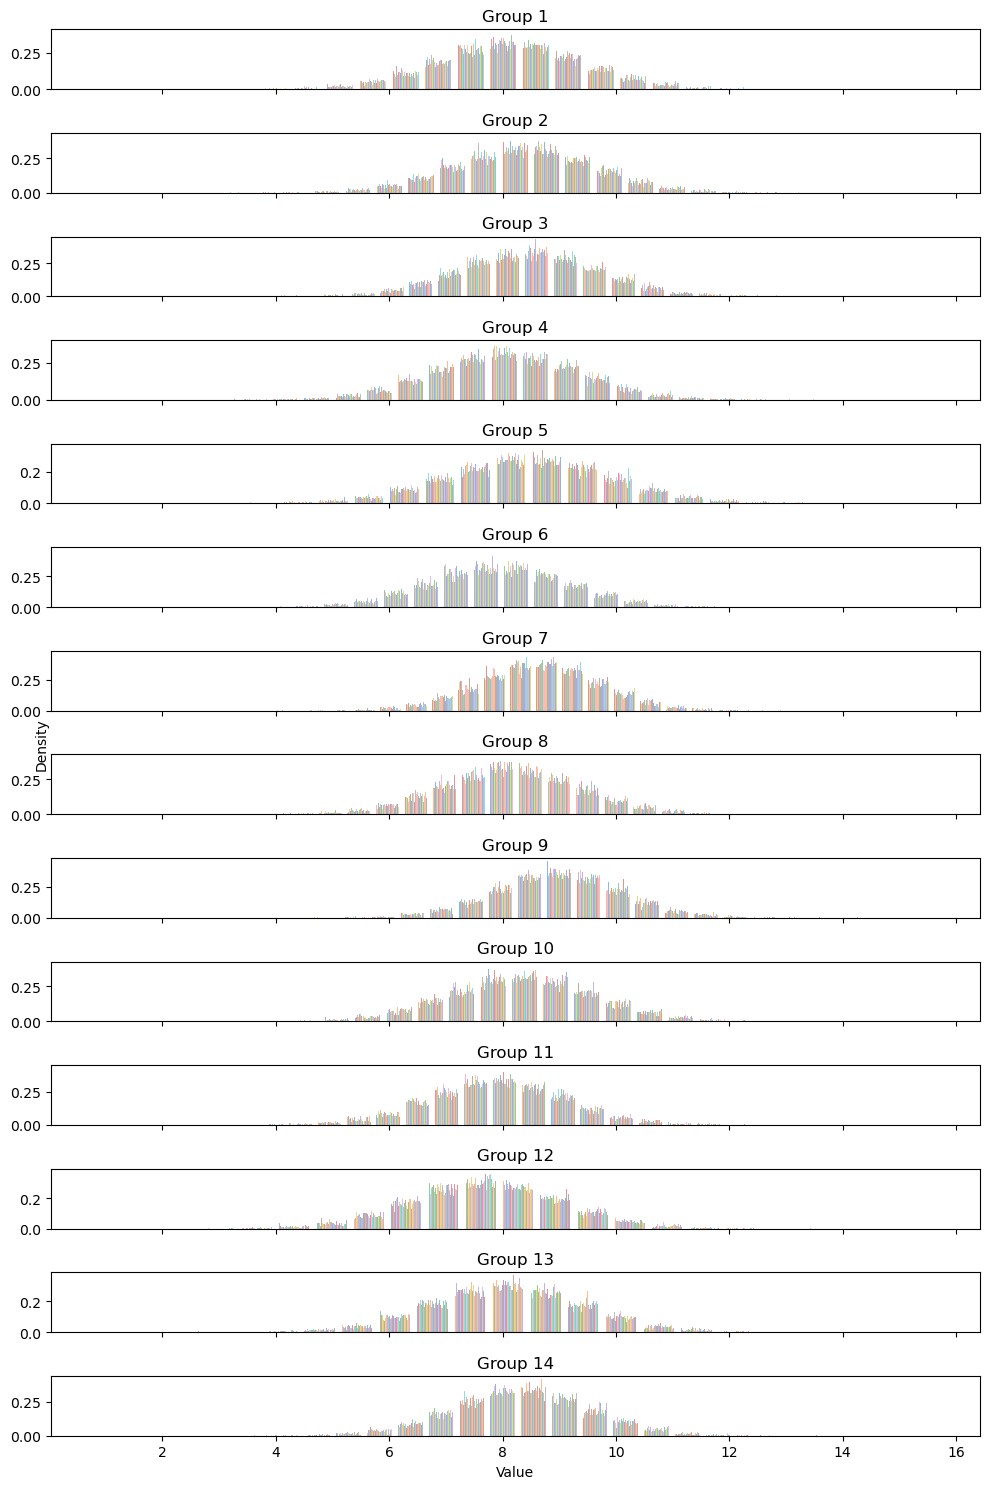

In [29]:


# Define the number of groups
n_groups = len(np.unique(idx))

fig, ax = plt.subplots(n_groups, figsize=(10, 15), sharex=True)

# Loop over each group
for i in range(n_groups):
    # Plot the histogram of the posterior predictive samples
    ax[i].hist(posterior_pred['y'][:, idx==i], bins=20, alpha=0.5, density=True)
    # Set the title of the subplot to the name of the group
    ax[i].set_title(f"Group {i+1}")
    
# Set the x and y labels of the entire plot
ax[-1].set_xlabel("Value")
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


In [32]:
# Now we're going to look at the school-aged population versus the target!

bins = pd.cut(pre_omi['School-Aged Population'], bins=4) # converting continuous data to bins
idx = pd.Categorical(bins).codes # getting codes from these bins
groups = len(np.unique(idx)) # sorting these into total number of codes

# Then use idx as before:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=7.5, sd=2, shape=groups)
    σ = pm.HalfNormal('σ', sd=2, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=target)

    trace_groups = pm.sample(5000, tune=5000)



/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_49007/3021418638.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_groups = pm.sample(5000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 31 seconds.


In [33]:
ww_by_school_pop = az.from_pymc3(trace=trace_groups)
ww_gaussian = az.summary(ww_by_school_pop)
ww_gaussian

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],8.147,0.047,8.057,8.236,0.000,0.0,34377.0,15266.0,1.0
μ[1],8.500,0.074,8.363,8.639,0.000,0.0,31453.0,15575.0,1.0
μ[2],8.577,0.088,8.409,8.742,0.001,0.0,28172.0,15745.0,1.0
μ[3],8.272,0.084,8.110,8.429,0.000,0.0,37101.0,16764.0,1.0
σ[0],1.233,0.033,1.171,1.295,0.000,0.0,33508.0,16153.0,1.0
σ[1],1.263,0.052,1.164,1.362,0.000,0.0,35176.0,15774.0,1.0
σ[2],1.249,0.064,1.132,1.372,0.000,0.0,33323.0,16393.0,1.0
σ[3],1.186,0.061,1.076,1.301,0.000,0.0,33907.0,15796.0,1.0


In [ ]:
# Our sigma scores here are pretty good! Better than the facility scores, which also maps to what we've previously
# seen with our regression models.

In [36]:
# Let's try school status! Let's get those values first

status = pre_omi['School Status'].values
status = set(list(status))
for i in status:
    print(i)

Pre-K and Special Only
Remote Learning Ended
Summer Break_2
Summer Break_1
Middle Schools Reopen
Mandatory_In-person
Shutdown
High_Schools_Reopen
All Grades
Grade Schools Reopen


In [37]:
# Let's convert to a useable schema


idx = pd.Categorical(pre_omi['School Status'],
                     categories=['Pre-K and Special Only', 'Remote Learning Ended', 'Summer Break_2', 'Summer Break_1', 'Middle Schools Reopen', 
                                 'Mandatory_In-person', 'Shutdown','High_Schools_Reopen', 'All Grades',
                                'Grade Schools Reopen']).codes
groups = len(np.unique(idx))


In [38]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=3, shape=groups) # lower mu since expecting variation between min and max
    σ = pm.HalfNormal('σ', sd=10, shape=groups) # higher sd since less certainty between groups

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=target)

    trace_groups = pm.sample(5000, tune=5000)

/var/folders/yf/9lmqvqdx2h3d7cgwxqhp7bnc0000gn/T/ipykernel_49007/4233900924.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_groups = pm.sample(5000, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 39 seconds.


In [39]:
ww_by_site = az.from_pymc3(trace=trace_groups)
ww_gaussian = az.summary(ww_by_site)
ww_gaussian

/Users/admin/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],6.559,0.220,6.146,6.974,0.001,0.001,27601.0,15056.0,1.0
μ[1],6.778,0.083,6.622,6.932,0.000,0.000,31557.0,14867.0,1.0
μ[2],8.168,0.065,8.043,8.286,0.000,0.000,32701.0,14857.0,1.0
μ[3],6.444,0.132,6.200,6.694,0.001,0.001,30312.0,14781.0,1.0
μ[4],9.325,0.083,9.170,9.482,0.000,0.000,32528.0,14924.0,1.0
μ[5],8.081,0.063,7.970,8.203,0.000,0.000,34244.0,14512.0,1.0
μ[6],8.824,0.134,8.569,9.072,0.001,0.001,29071.0,14578.0,1.0
μ[7],8.268,0.068,8.143,8.396,0.000,0.000,31902.0,15019.0,1.0
μ[8],7.866,0.063,7.749,7.986,0.000,0.000,30986.0,15638.0,1.0
μ[9],9.575,0.036,9.508,9.642,0.000,0.000,32087.0,14227.0,1.0


In [ ]:
# Higher mean variance, as expected. Very tight sigmas, so our model here is doing pretty well.
